**01_TWRI**

In [1]:
import os; import pathlib as pl ; import flopy ; import git ; import matplotlib.pyplot as plt ; import pandas as pd 
import numpy as np ; from flopy.plot.styles import styles  ; from modflow_devtools.misc import get_env, timed ; from pathlib import Path
import matplotlib as mpl; import csv 

In [2]:
sim_name = "ex-gwf-twri01" ; output_folder = Path("./01_TWRI") ; output_folder.mkdir(exist_ok=True)  
parameter_units = {"recharge": "$ft/s$"}  ; length_units = "feet"  ; time_units = "seconds" 
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder

In [3]:
nper = 1 ; nlay = 5     ; ncol = 15      ; nrow = 15               ; delr = 5000   ; delc = 5000
top  = 200  ; botm_str = "-150.0, -200.0, -300.0, -350.0, -450.0"  ; strt = 0.0    ; icelltype_str = "1, 0, 0, 0, 0"  
k11_str = "1.0e-3, 1.0e-8, 1.0e-4, 5.0e-7, 2.0e-4"                 ; k33_str = ("1.0e-3, 1.0e-8, 1.0e-4, 5.0e-7, 2.0e-4")  ; recharge = 3e-8  

perlen = 8.640e04 ;  nstp = 1 ; tsmult = 1.0 ; tdis_ds = ((perlen, nstp, tsmult),)  ; nouter = 50  ; ninner = 100  ; hclose = 1e-9   ; rclose = 1e-6

botm = [float(value) for value in botm_str.split(",")]             ; k11       = [float(value) for value in k11_str.split(",")]
k33  = [float(value) for value in k33_str.split(",")]              ; icelltype = [int  (value) for value in icelltype_str.split(",")]  #_ic_chd

In [4]:
chd_spd = []             # { dictinaries } 
for k in (0, 2):
    chd_spd += [[k, i, 0, 0.0] for i in range(nrow)]    
chd_spd = {0: chd_spd}

wel_spd = {0: [[4, 4, 10, -5.0],[2, 3, 5, -5.0],[2, 5, 11, -5.0],[0, 8, 7, -5.0],[0, 8, 9, -5.0],[0, 8, 11, -5.0],[0, 8, 13, -5.0],[0, 10, 7, -5.0],
        [0, 10, 9, -5.0],[0, 10, 11, -5.0],[0, 10, 13, -5.0],[0, 12, 7, -5.0],[0, 12, 9, -5.0],[0, 12, 11, -5.0],[0, 12, 13, -5.0],]}

drn_spd = {0: [[0, 7, 1, 0.0, 1.0e0],[0, 7, 2, 0.0, 1.0e0],[0, 7, 3, 10.0, 1.0e0],[0, 7, 4, 20.0, 1.0e0],[0, 7, 5, 30.0, 1.0e0],
               [0, 7, 6, 50.0, 1.0e0],[0, 7, 7, 70.0, 1.0e0],[0, 7, 8, 90.0, 1.0e0],[0, 7, 9, 100.0, 1.0e0],]}   ; top, botm

(200, [-150.0, -200.0, -300.0, -350.0, -450.0])

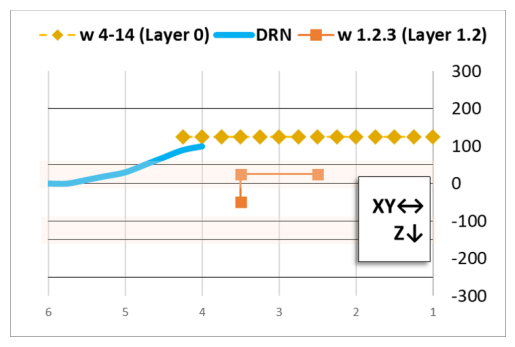

layers [200, 50.0, 0.0, -100.0, -150.0, -250.0]         chd (30, 4) wel (15, 4) drn (9, 5)


In [5]:
row = chd_spd  [0] ; sa1 = pd.DataFrame(row);  sa1.to_csv (output_folder / "a_chd.csv")      
row = wel_spd  [0] ; sa2= pd.DataFrame(row) ;  sa2.to_csv (output_folder / "b_wel_spd.csv")  
row = drn_spd  [0] ; sa3 = pd.DataFrame(row);  sa3.to_csv (output_folder / "c_drn_spd.csv")  
image = plt.imread('_aux\\01_TWRI.png'); fig, ax = plt.subplots() ; ax.imshow(image) ; ax.axis('off') ; plt.show() 
top_list = [top]; top_list.extend([i+top for i in botm])   
# sa1 = pd.DataFrame(top);   sa2 = pd.DataFrame(botm); frames = [sa1, sa2] ; rs = pd.concat(frames); rs.values.tolist() # see ex:02
print('layers',top_list, '   ', '   ', 'chd',sa1.shape, 'wel',sa2.shape,'drn',sa3.shape)

In [6]:
sim_ws = os.path.join(workspace, sim_name)
sim    = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name=exe_name)
gwf    = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)

flopy.mf6.ModflowGwfdis  (gwf, length_units=length_units,          nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
flopy.mf6.ModflowTdis    (sim, nper =nper, perioddata =tdis_ds, time_units =time_units)
flopy.mf6.ModflowIms     (sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
flopy.mf6.ModflowGwfnpf  (gwf,cvoptions="perched",perched=True,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True)  # Node P. Flow
flopy.mf6.ModflowGwfic   (gwf, strt=strt)                         
flopy.mf6.ModflowGwfchd  (gwf, stress_period_data=chd_spd)
flopy.mf6.ModflowGwfdrn  (gwf, stress_period_data=drn_spd)
flopy.mf6.ModflowGwfwel  (gwf, stress_period_data=wel_spd)
flopy.mf6.ModflowGwfrcha (gwf, recharge=recharge)                 ; head_filerecord = f"{sim_name}.hds"   ;  budget_filerecord = f"{sim_name}.cbc"
flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
sim.write_simulation(silent=True)  ; sim.run_simulation(silent=True)

(True, [])

In [7]:
sim_ws=os.path.join(workspace,sim_name) ;gwf=sim.get_model(sim_name) ; hobj=gwf.output.head() ; head=hobj.get_data() ; cobj=gwf.output.budget()  
print('heads=', head.shape); sv = head.reshape(head.shape[0],-1)     ; then=pd.DataFrame(sv)  ; then.to_csv (output_folder / 'd_H_3D.csv' )  

heads= (5, 15, 15)


In [8]:
head2 = np.flip(head,1)

## **L = 0,1,2,3 layers**

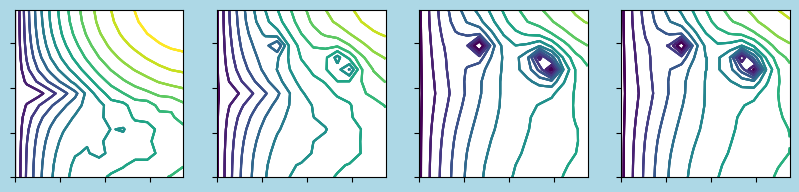

In [9]:
def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        L = 0; ax1.contour( head2 [L,:,:]   ,levels=np.arange(L, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
        L = 1; ax2.contour( head2 [L,:,:]   ,levels=np.arange(L, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
        L = 2; ax3.contour( head2 [L,:,:]   ,levels=np.arange(L, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
        L = 3; ax4.contour( head2 [L,:,:]   ,levels=np.arange(L, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
        ax.tick_params(labelbottom=False, labelleft=False)
fig = plt.figure(figsize=(10, 10),facecolor='lightblue')    
ax1 = plt.subplot2grid((4, 4), (1, 0))        
ax2 = plt.subplot2grid((4, 4), (1, 1))  
ax3 = plt.subplot2grid((4, 4), (1, 2))  
ax4 = plt.subplot2grid((4, 4), (1, 3))  ; annotate_axes(fig) ; plt.show()

## **L = 1,2,3,4**

<Figure size 500x500 with 0 Axes>

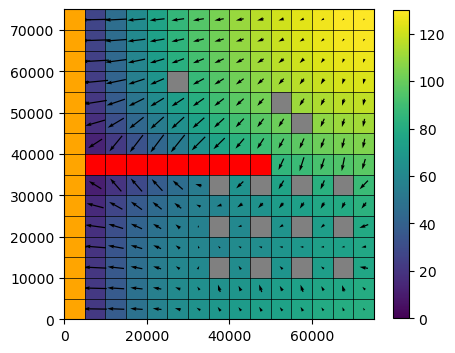

In [10]:
fig = plt.figure(figsize=(5, 5))
L = 0; ax.contour( head2 [L,:,:]   ,levels=np.arange(L, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
L = 0  ;     qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
fig = plt.figure(figsize=(5, 5))        
mm = flopy.plot.PlotMapView(model=gwf, layer=L, extent=gwf.modelgrid.extent) ; cbv = mm.plot_array(head) ;  q = mm.plot_vector(qx, qy)  
mm.plot_bc("WEL", plotAll=True, color = 'grey' ) ; mm.plot_bc("CHD", plotAll=True, color = 'orange' ); mm.plot_bc("DRN", plotAll=True, color = 'red' )
mm.plot_grid(lw=0.5, color="black")  ; cb = plt.colorbar(cbv, ax=mm.ax, shrink=.8) 